In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

2024-04-06 10:40:29.595213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 10:40:29.595340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 10:40:29.692752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the Oxford Flowers 102 dataset
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
# Get the class names
class_names = info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteP8IJ4L/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteP8IJ4L/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteP8IJ4L/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [3]:
print('train',len(dataset['train']))
print('test',len(dataset['test']))
print('validation',len(dataset['validation']))
print('Number of classes',len(class_names))

train 1020
test 6149
validation 1020
Number of classes 102


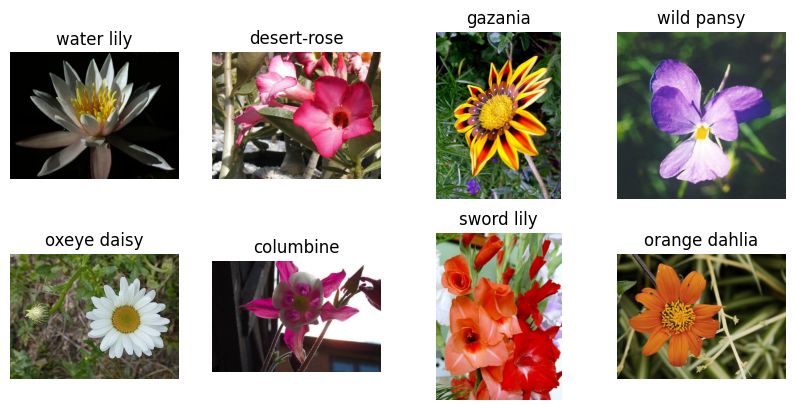

In [4]:
# visualize examples
plt.figure(figsize=(10, 10))
vis_ds = dataset['train'].take(8)
for i,(img, lbl) in enumerate(vis_ds):
  image = img
  label = lbl
  plt.subplot(4, 4, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  label_str = class_names[label]
  plt.title(label_str)
  plt.axis("off")

In [5]:
# Augment images
IMG_SIZE=224
def augment_data(image,label):
    # Apply random horizontal flip
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, 0.2)
    # Apply random contrast adjustment
    image = tf.image.random_contrast(image, 0.8, 1.2)

    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    return image, label


def resize(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

In [6]:
# Load pre-trained ResNet50 without top classification layer
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
# # Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Number of layers in the base model:  175


In [7]:
# Fine-tune from this layer onwards
# fine_tune_at = 150

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False
# # Freeze the base model
base_model.trainable = False
# Add a classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2048, activation='relu')(x)
# x = Dense(512, activation='relu')(x)

output = Dense(info.features['label'].num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size =16
train_ds = (
    dataset['train']
    .map(augment_data, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
    
val_ds = (
    dataset['validation']
    .map(resize, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,           # Reduce learning rate by a factor of 0.2
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,          # Minimum learning rate allowed
    verbose=1             # Print a message when learning rate is reduced
)

In [10]:
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/50
 5/64 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0427 - loss: 6.1100

I0000 00:00:1712400119.070002      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712400119.119763      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.1379 - loss: 4.9424

W0000 00:00:1712400130.695194      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - accuracy: 0.1395 - loss: 4.9246 - val_accuracy: 0.5598 - val_loss: 1.8463 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.7272 - loss: 1.0885 - val_accuracy: 0.6422 - val_loss: 1.3038 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8735 - loss: 0.4778 - val_accuracy: 0.7216 - val_loss: 0.9770 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9395 - loss: 0.2811 - val_accuracy: 0.7167 - val_loss: 1.0047 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9700 - loss: 0.1584 - val_accuracy: 0.7324 - val_loss: 1.0048 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9752 - loss: 0.1102 - val_accuracy: 0.7755 - val_loss: 0.8488 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9890 - loss: 0.0587 - val_accuracy: 0

In [11]:
# Evaluate the trained model on testset
test_ds = (
    dataset['test']
    .map(resize, num_parallel_calls=AUTOTUNE)
    .batch(1)
    .prefetch(AUTOTUNE)
)

test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)# Evaluate the model

6149/6149 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - accuracy: 0.8060 - loss: 0.8099
Test accuracy: 0.8100504279136658


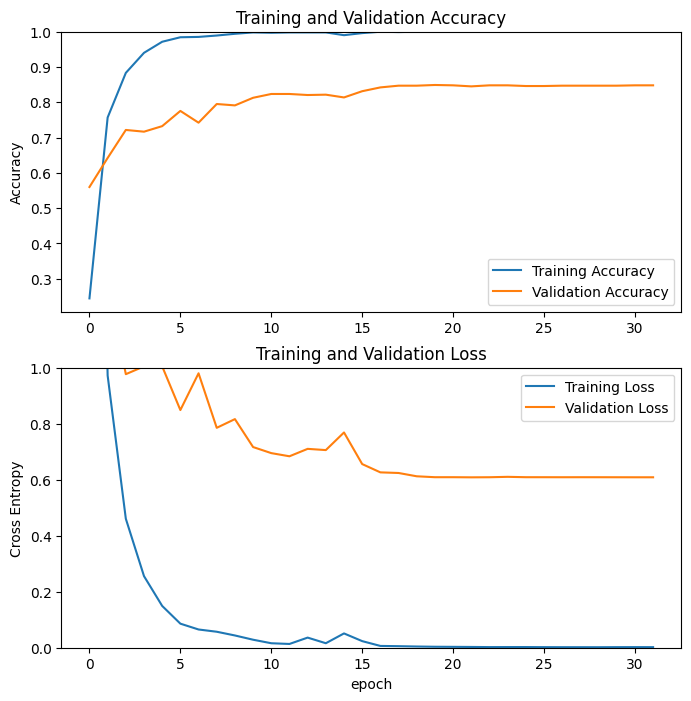

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [13]:
# Save model
model.save('flowers_clf.keras')

## Loading model and predicting on a new image

In [14]:
# predicting on new image
loaded_model = tf.keras.models.load_model('flowers_clf.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 434 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [15]:
# Download water lily test image
!wget -O test_img.jpg https://m.media-amazon.com/images/I/61lSrpCxNkL._AC_UF1000,1000_QL80_.jpg -q
# !wget -O test_img.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTpiKI_UOr3vTrj30GCg3jpaxVj3W6B6cZx6sWrxYXtig&s -q
# https://www.pondplantsonline.com/cdn/shop/products/InnerLight_grande.jpg?v=1447015171

In [16]:
import numpy as np
# Predict on a new image
new_image = tf.keras.preprocessing.image.load_img('test_img.jpg', target_size=(224, 224))
new_image = tf.keras.preprocessing.image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)

predictions = model.predict(new_image)

print(np.argmax(predictions))
# Get the predicted class
predicted_class = np.argmax(predictions[0])

# Print the predicted class name
print('Predicted class:', class_names[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
80
Predicted class: frangipani
